# BAKU - Time Measurement and Code Generation
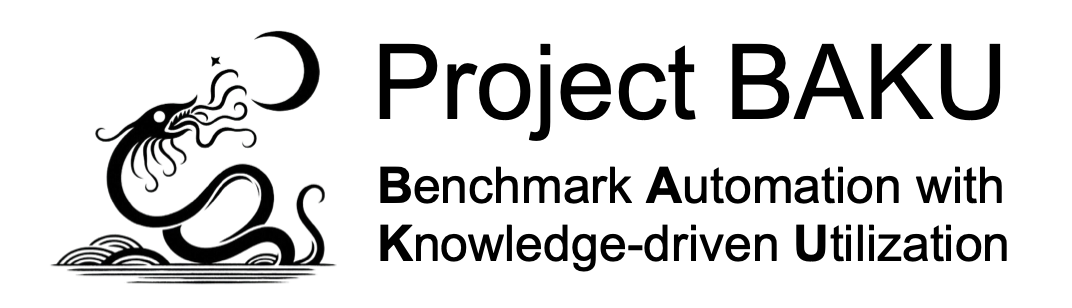

This notebook is fine-tuning language models (LLMs). The adapter used are IA3 and LoRA. The dataset is setup with 600 examples, in two classes, input and output.

### Imports & Setup

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import matplotlib.pyplot as plt #plots

import pandas as pd #for csv

import evaluate #for evaluation

from peft import PeftModel, PeftConfig, get_peft_model, IA3Config, TaskType, prepare_model_for_kbit_training #PEFT

from peft import TaskType

from datasets import load_dataset, DatasetDict, Dataset #Dataset loader

from torch.nn import functional as F
import torch

from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM, DataCollatorForCompletionOnlyLM

from google.colab import drive #to import the csv and other data
from google.colab import auth
from google.colab import userdata
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import json

In [4]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [5]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/"
data_loss = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/final_model_IA3/training_logs.csv"
outputs_folder = data_folder+"dts"

data_files = {"train" : data_folder+"training.jsonl", "test": data_folder+"/testing.jsonl", "eval": data_folder+"evaluating.jsonl"}
dataset = load_dataset("json",data_files=data_files) #sample size 200

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

### Model Setup - Training

In [ ]:
from transformers import BitsAndBytesConfig
model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"

use_flash_attention = False

# BitsAndBytesConfig int-4 config
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True, bnb_8bit_use_double_quant=True, bnb_8bit_quant_type="nf4", bnb_8bit_compute_dtype=torch.bfloat16
# ) # we can do it in 8 bit

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
      use_flash_attention_2=use_flash_attention,
    use_cache=False,
    device_map="auto",
)

model.config.pretraining_tp = 1


print(model)

### Functions

In [ ]:
def formater_prompts(texts):
  instruction_text = texts['instruction']
  response_text = texts['response']
  return f"""{instruction_text}
  {response_text}"""

In [ ]:
# tokenized_dataset = dataset.map(tokenization, batched=True)
# tokenized_dataset

In [ ]:
response_template= "# Answer:"
data_collator = DataCollatorForCompletionOnlyLM(response_template=response_template,tokenizer=tokenizer)

### Training Setup

In [ ]:
peft_config = IA3Config(task_type=TaskType.CAUSAL_LM, target_modules=["k_proj", "v_proj", "down_proj","gate_proj","up_proj"], feedforward_modules=["down_proj","gate_proj","up_proj"])


In [ ]:
peft_config

In [ ]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
lr = 5e-4
batch_size = 5
num_epochs = 40

In [ ]:
training_args = TrainingArguments(
    output_dir=outputs_folder,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="no",
    save_strategy="epoch",
    save_steps=100,
    load_best_model_at_end=False,
    logging_strategy="steps",
    logging_steps=10,
    report_to="none",
    tf32=True,
    max_grad_norm=1.0,
    warmup_ratio=0.01,
    lr_scheduler_type="constant",
    disable_tqdm=True
)


In [ ]:
# creater trainer object

# model.gradient_checkpointing_enable()

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    processing_class=tokenizer,
    formatting_func=formater_prompts,
    args=training_args,
)


In [ ]:
trainer.train()

In [ ]:
train_df = pd.DataFrame(trainer.state.log_history)

In [ ]:
trainer.save_model(data_folder+"final_model_IA3")

In [ ]:
train_df.to_csv("/content/drive/MyDrive/Colab_Notebooks/Baku/data/lossIA3.csv",index=False)

### Model setup - Load

In [6]:
model_name = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/final_model_IA3"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    device_map="auto",
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [7]:
def graph_training(y="loss", x="step"):
  df_loss = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Baku/data/final_model_IA3/lossIA3.csv")
  df_loss = df_loss.dropna(subset=[y])


  plt.figure(figsize=(10, 5))
  plt.plot(df_loss[x], df_loss[y], marker="o", linestyle="-", label=y.upper())
  plt.xlabel(x.upper())
  plt.ylabel(y.upper())
  plt.title("Training Evolution: "+y.upper()+" VS "+x.upper())
  plt.legend()
  plt.grid()
  plt.show()

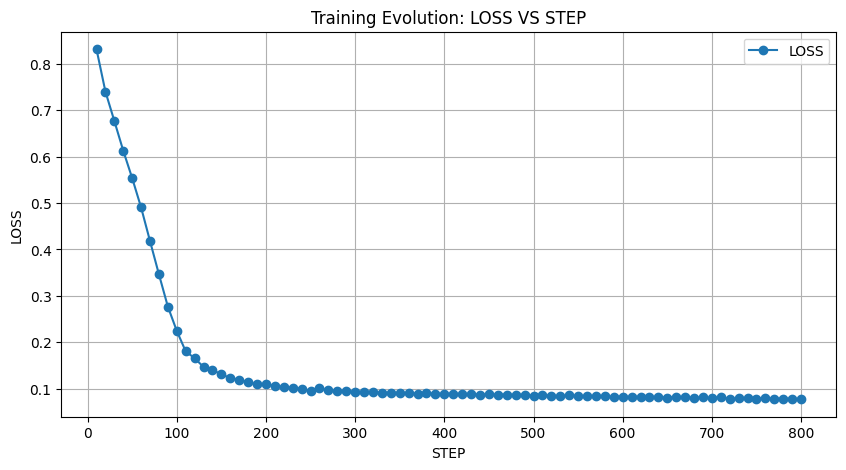

In [8]:
graph_training()

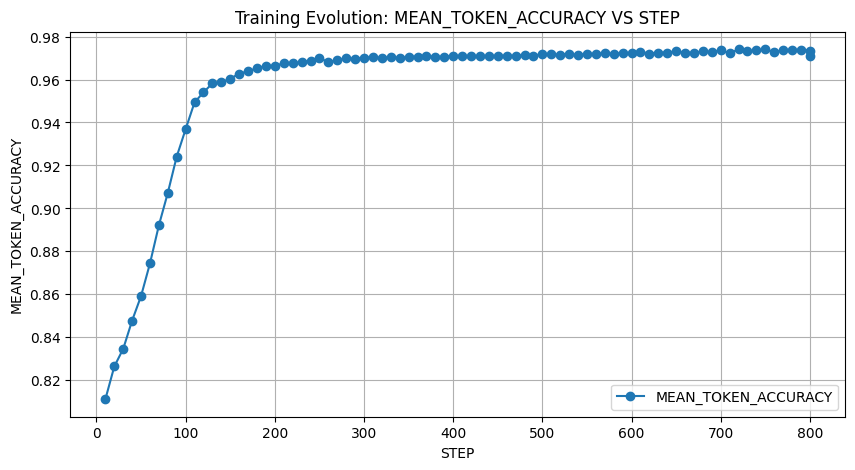

In [9]:
graph_training(y="mean_token_accuracy")

### Run the dataset and dowload the files

In [10]:
auth.authenticate_user()

In [ ]:
import time
import string
import random

def run_dataset(dataset,tokenizer,name):
  #pre-set the enviroment
  folder_id = ""
  train = dataset[name]
  data_path = "/content/drive/MyDrive/Colab_Notebooks/Baku/data/final_model_IA3/programs_IA3.csv"

  i = 0
  for item in train:
    dataframe = pd.read_csv(data_path)
    input = item["instruction"]

    #generation
    input_time = time.time()
    input_tokens = tokenizer(input, return_tensors="pt").to(model.device)
    outputs = model.generate(**input_tokens, max_length=4096) #model output
    output_time = time.time()
    dif_seconds = (output_time - input_time)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    output = decoded_output

    print(input)
    print(output)

    try:
      size = 4
      chars=string.ascii_uppercase + string.digits
      random_name = ''.join(random.choice(chars) for _ in range(size))
      while random_name in dataframe['id'].values:
          random_name = ''.join(random.choice(chars) for _ in range(size))
      program_name = random_name

      local_file_path = f"/content/{program_name}.c"


      with open(local_file_path, "w") as file:
        file.write(output)


      file_metadata = {
          'name': f'{program_name}.c',
          'parents': [folder_id]
      }

      media = MediaFileUpload(local_file_path, mimetype='text/plain')
      service = build('drive', 'v3')
      uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
      print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")

      new_values = [program_name,dif_seconds,i,False]

      new_row = pd.DataFrame([dict(zip(dataframe.columns, new_values))])
      dataframe.to_csv(data_path, index=False)
      dataframe = pd.concat([dataframe, new_row], ignore_index=True)
      dataframe.to_csv(data_path, index=False)

    except Exception as e:
      print(f"File could not be uploaded. ERROR: {e}")

    i = i + 1



In [ ]:
run_dataset(dataset,tokenizer,"train")